 <h1 align="center">1. Segmentation of electron microscopy image</h1>

### About scikit-image
* <b>scikit-image</b> is a Python package containing algorithms for image processing, http://scikit-image.org/docs/dev/user_guide

### Installation
* using ```pip``` program: ```pip install scikit-image```
* using Anaconda Distribution: ```conda install scikit-image```
* more details about installation: http://scikit-image.org/docs/dev/install.html

### Image to segment
* scanning electron microscopy image of a multiphase glass

### Import other libraries

In [1]:
from __future__ import division, print_function
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt, cm

In [2]:
from skimage import io
from skimage import img_as_float

### Read and pre-process the data

In [3]:
im = io.imread('Data/phase_separation.png')

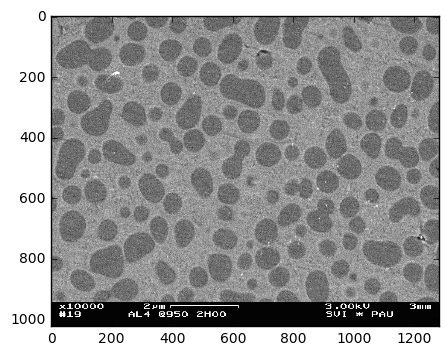

In [4]:
plt.imshow(im, cmap='gray')

In [5]:
im.dtype, im.shape

(dtype('uint8'), (1024, 1280))

* First segmentation idea?
* Remove the information bar at the bottom. We want to retain only the region of the image that we will process

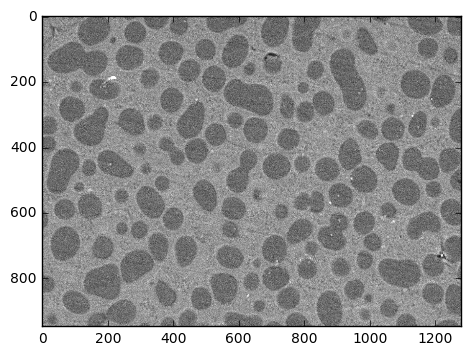

In [6]:
phase_separation = im[:947]
plt.imshow(phase_separation, cmap='gray')

* We can use NumPy arrays to count the exact number of lines to be retained in the image

In [7]:
np.nonzero(np.all(im < 0.1 * im.max(), axis=1))[0][0]

947

* How to separate blobs from backgroud?

### Compute histogram

In [8]:
from skimage import exposure

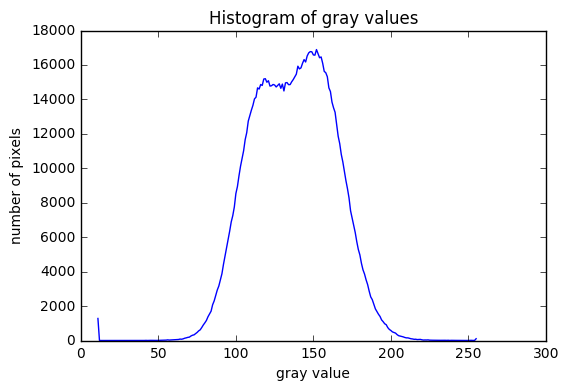

In [9]:
histogram = exposure.histogram(phase_separation)
plt.plot(histogram[1], histogram[0])
plt.xlabel('gray value')
plt.ylabel('number of pixels')
plt.title('Histogram of gray values')

### Thresholding

In [10]:
threshold = 110
print(threshold)

110


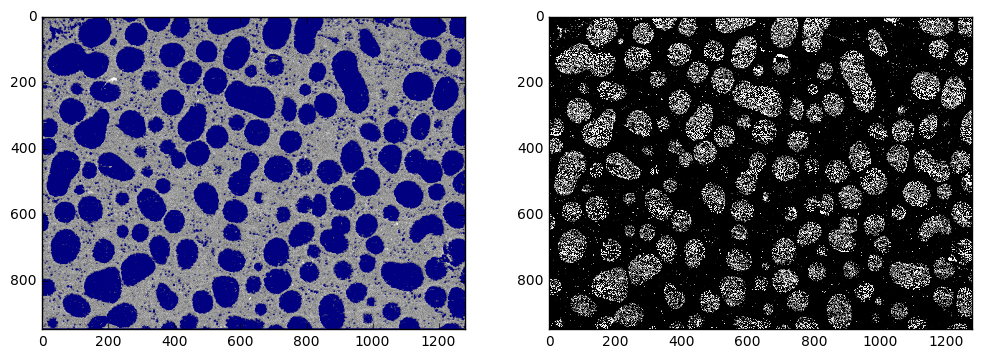

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
ax[0].imshow(phase_separation, cmap='gray')
ax[0].contour(phase_separation, [threshold])
ax[1].imshow(phase_separation < threshold, cmap='gray')

### Otsu Thresholding

* The goal is to find a threshold that classifies the image into two clusters such that we minimize the area under the histogram for one cluster that lies on the other cluster's side of the threshold.
* This is equivalent to minimazing the within class variance or equivalently maximizing the between class variance.
* A good tutorial about Otsu segmentation: http://www.labbookpages.co.uk/software/imgProc/otsuThreshold.html

In [12]:
from skimage import filters

In [13]:
threshold = filters.threshold_otsu(phase_separation)
print(threshold)

136


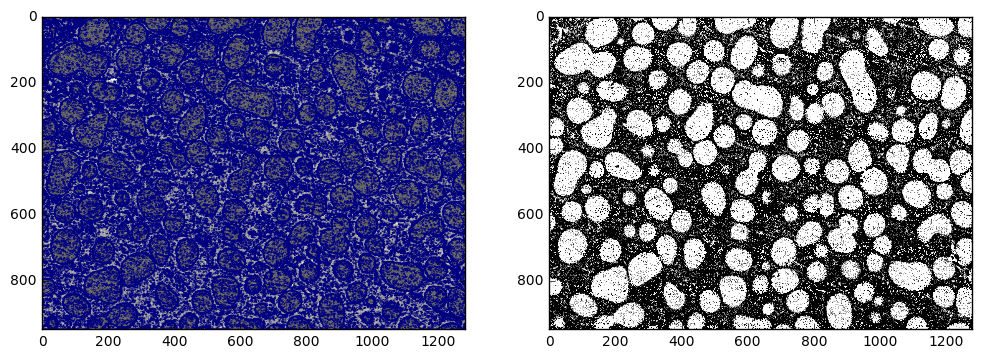

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
ax[0].imshow(phase_separation, cmap='gray')
ax[0].contour(phase_separation, [threshold])
ax[1].imshow(phase_separation < threshold, cmap='gray')

* What we observe?

### Denoising filters

* How noise looks like?

17.6722091149


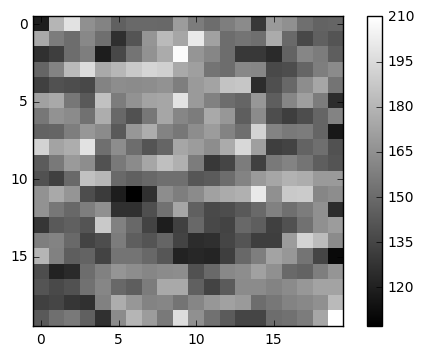

In [15]:
plt.imshow(phase_separation[390:410, 820:840], cmap='gray', 
           interpolation='nearest')
plt.colorbar()
print(phase_separation[390:410, 820:840].std())

- The image has random variations of gray levels that originate from the imaging process. 
- Noise can be due to low photon-counting, or to electronic noise on the sensor, although other sources of noise are possible as well.
- The most common denoising filters average together the pixels that are close to each other.
- The most common denoising filter: <b>median filter</b>: https://en.wikipedia.org/wiki/Median_filter
- <b> Median Filter </b> replaces the value of a pixel by the median gray value inside a neighbourhood of the pixel. Taking the median gray value preserves edges much better than taking the mean gray value.
- We use a square neighbourhood of size 7x7: the larger the window size, the larger the attenuation of the noise, but this may come at the expense of precision for the location of boundaries. Choosing a window size therefore represents a trade-off between denoising and accuracy.

In [16]:
from skimage import restoration
from skimage import filters

In [17]:
median_filtered = filters.median(phase_separation, np.ones((7, 7)))

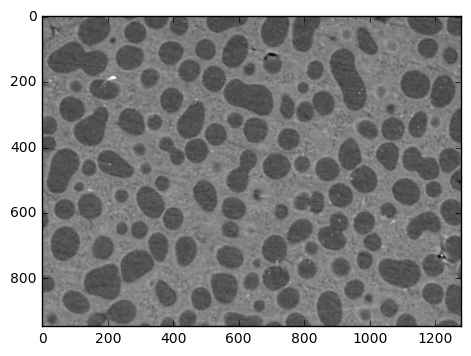

In [18]:
plt.imshow(median_filtered, cmap='gray')

5.53366063289


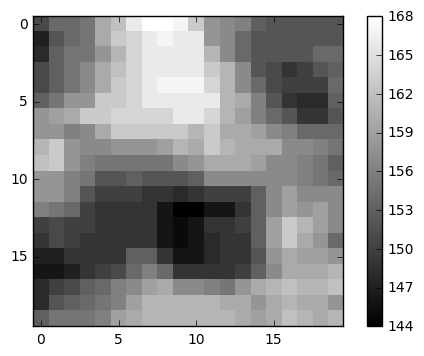

In [19]:
plt.imshow(median_filtered[390:410, 820:840], cmap='gray', 
           interpolation='nearest')
plt.colorbar()
print(median_filtered[390:410, 820:840].std())

* Variations of gray levels inside zones that should be uniform are now smaller in range, and also spatially smoother.

### Histogram of the denoised image

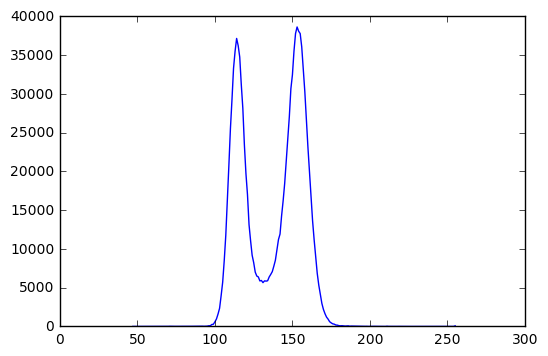

In [20]:
histo_median = exposure.histogram(median_filtered)
plt.plot(histo_median[1], histo_median[0])

### Otsu Thresholding of the denoised image

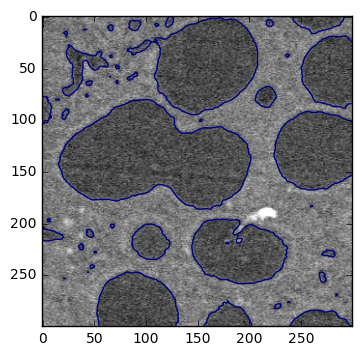

In [21]:
plt.imshow(phase_separation[:300, :300], cmap='gray')
plt.contour(median_filtered[:300, :300], 
            [filters.threshold_otsu(median_filtered)])

In [22]:
binary_image = median_filtered < filters.threshold_otsu(median_filtered)

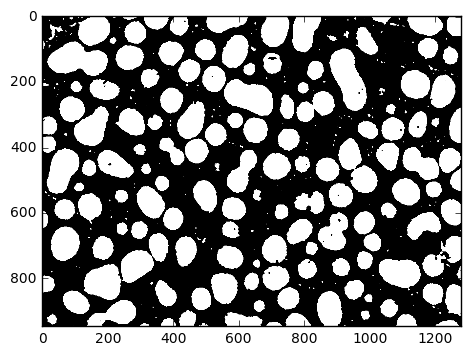

In [23]:
plt.imshow(binary_image, cmap='gray')

* Still not what we want?
* What to do?

### Morphological operators

* Good reference for morphological operators: http://homepages.inf.ed.ac.uk/rbf/HIPR2/morops.htm

In [24]:
from skimage import morphology

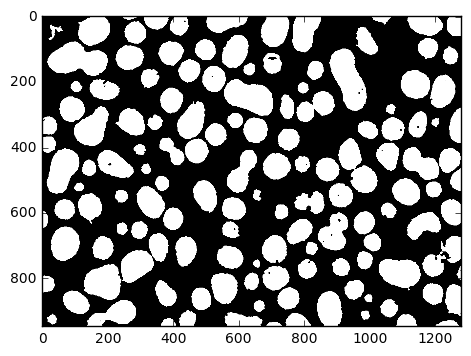

In [25]:
only_large_blobs = morphology.remove_small_objects(binary_image, 
                                                   min_size=300)
plt.imshow(only_large_blobs, cmap='gray')

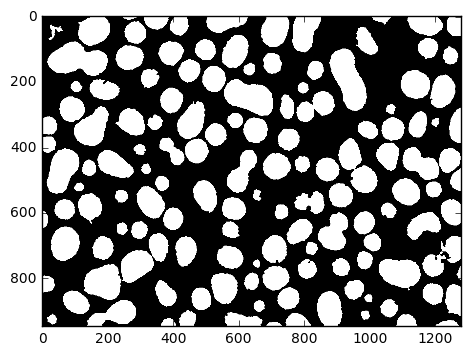

In [26]:
only_large = np.logical_not(morphology.remove_small_objects(
                                    np.logical_not(only_large_blobs), 
                                                   min_size=300))
plt.imshow(only_large, cmap='gray')

* What is the result? ... a binary image

### Measuring region properties

The segmentation of foreground (objects) and background results in a binary image. In order to measure the properties of the different blobs, one must first attribute a different label to each blob (identified as a connected component of the foreground phase). Then, the utility function ```measure.regionprops``` can be used to compute several properties of the labeled regions.

Properties of the regions can be used for classifying the objects, for example with scikit-learn (machine learning package in Python), http://scikit-learn.org/stable/.

In [27]:
from skimage import measure

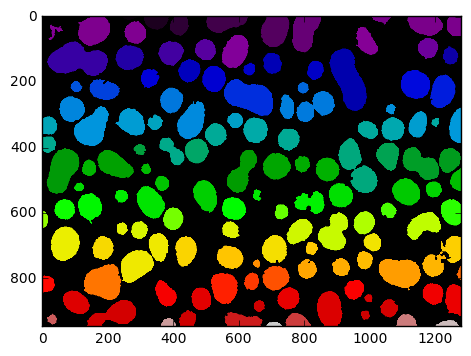

In [28]:
labels = measure.label(only_large)
plt.imshow(labels, cmap='spectral')

In [29]:
props = measure.regionprops(labels, phase_separation)

In [30]:
areas = np.array([prop.area for prop in props])
perimeters = np.array([prop.perimeter for prop in props])

In [31]:
perimeters

array([ 117.52691193,  213.88225099,  218.40916293,  328.16652224,
        321.17871555,  366.00714267,  158.08326112,  297.37972568,
        201.01219331,  343.63455967,  228.69343418,  196.06601718,
        270.80003589,  315.70562748,  212.65180362,  218.23759005,
        255.07821049,  521.87214973,  276.8355698 ,  175.50966799,
        516.65894629,  209.99494937,  231.03657993,  181.09545443,
        126.81118318,  255.66399692,  207.48023074,  301.42135624,
        308.97770542,  452.03152929,  292.10764774,  116.71067812,
        110.56854249,  245.5218613 ,  416.54624792,  208.99494937,
        264.35028843,  351.84776311,  107.98275606,  384.33304448,
        265.78174593,  293.07821049,  232.37972568,  157.78174593,
        164.16652224,  188.12489168,  243.03657993,  259.27922061,
         91.08326112,  204.55129855,  228.45079349,  225.72287143,
        166.56854249,  276.24978336,  569.36962441,  245.27922061,
        262.59292911,  130.84671709,  372.19090886,  237.37972

In [32]:
perimeters**2

array([  13812.57502888,   45745.61729022,   47702.56245112,
        107693.26632   ,  103155.76732247,  133961.22848907,
         24990.31744655,   88434.70124371,   40405.90185882,
        118084.71060159,   52300.68683519,   38441.88309204,
         73332.65944006,   99670.04322555,   45220.78958097,
         47627.64571224,   65064.89346515,  272350.54065978,
         76637.93270631,   30803.64355862,  266936.46678206,
         44097.87875928,   53377.90126412,   32795.56361503,
         16081.07618003,   65364.07932337,   43048.04614807,
         90854.83399594,   95467.22244872,  204332.50347458,
         85326.87786722,   13621.38238692,   12225.40258945,
         60280.98437656,  173510.77665484,   43678.88886055,
         69881.07499062,  123796.84840446,   11660.27560573,
        147711.88908137,   70639.93646988,   85894.83746215,
         54000.3369057 ,   24895.07934888,   26950.64702483,
         35390.97487   ,   59066.77918235,   67225.71424198,
          8296.16045638,

In [33]:
areas

array([  548,  2702,  2845,  5161,  6769,  7283,  1139,  5406,  2669,
        6969,  3507,   712,  3699,  6146,  2974,  3196,  4312, 12990,
        5064,  1897, 13048,  2850,  3601,  2276,  1045,  4458,  2461,
        6212,  5886, 11523,  4298,   887,   895,  4161,  6541,  2500,
        4669,  6868,   675,  8351,  3335,  5224,  3429,  1718,  1560,
        2189,  3927,  4549,   467,  2557,  3506,  3445,  1812,  3340,
       10231,  4190,  4400,   900,  6950,  3837,  9309,  6600,  6293,
        5232,  1768,  4079,  1667,   735,  1873,  1537,  5376,  5279,
        1884,   615,  4275,  6052,   641,  1209,  4212,  4665,  4012,
        3056,  4223,  1668,  1494,  3304,   809,  3527,  5610,  7148,
        4308,  2111,  2039,   990,  7194, 11337,  2256,  5031,  3565,
        4616,  3727,  1137,  4405,  2096,  3594,  2267,  2574,  8892,
         414,  9414,   485,  4712,  1841,  6035,  1666,  2767,  3571,
        3260,  4074,  3513,  3344,  4297,  6654,   475,  2192,  7019,
         922,  1977,

In [35]:
perimeters**2./areas

array([ 25.20542888,  16.93028027,  16.76715728,  20.8667441 ,
        15.2394397 ,  18.39368783,  21.94057721,  16.35862028,
        15.1389666 ,  16.94428334,  14.91322693,  53.99140884,
        19.82499579,  16.21705877,  15.20537646,  14.90226712,
        15.08926101,  20.96616941,  15.13387297,  16.23808306,
        20.458037  ,  15.47293992,  14.82307727,  14.4092986 ,
        15.38858965,  14.66219814,  17.49209514,  14.62569768,
        16.21937181,  17.73257862,  19.85269378,  15.35668815,
        13.6596677 ,  14.48713876,  26.52664373,  17.47155554,
        14.96703255,  18.02516721,  17.27448238,  17.68792828,
        21.18139025,  16.4423502 ,  15.74812975,  14.49073303,
        17.27605579,  16.16764498,  15.04119663,  14.77813019,
        17.76479755,  16.3634078 ,  14.88584285,  14.78978656,
        15.31185395,  22.84848587,  31.68622512,  14.35844775,
        15.67160146,  19.02318153,  19.93180901,  14.68572691,
        17.40973061,  22.15991209,  17.09042851,  15.03

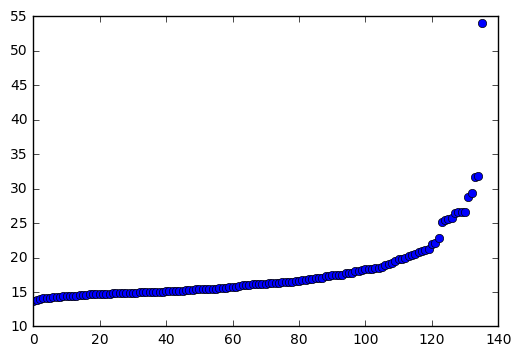

In [34]:
plt.plot(np.sort(perimeters**2./areas), 'o')

### Resources

* scikit-learn: Machine Learning in Python: http://scikit-learn.org/stable/
* Examples using scikit-image: http://scikit-image.org/docs/dev/auto_examples/
* Tutorial on image segmentation: http://docs.w3cub.com/scikit_image/user_guide/tutorial_segmentation/
